# Part 2 solution

To begin part 2, port your final (working) FWI workflow from part 1 into the notebook labeled solution_part2.ipynb. In this part, we will then play around with the acquisition geometry (source and receiver numbers and locations) and discuss the results.

Construct a few different acquisition geometries by varying the source and receiver locations and their numbers (note that you shouldn't increase the numbers of sources and receivers too much!), compare the results to those of part 1 and write a short explanation regarding why each configuration results in a better or worse image.

(In this section, feel free to increase the number of FWI iterations a little if you feel this aids your descriptions, but note that this is not strictly necessary).

In [13]:
# This cell contains the various imports we will need
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from devito import configuration
configuration['log-level'] = 'WARNING'

%matplotlib inline

#### Define the physical problem

In [14]:
#Load 2D Marmousi velocity model, update the path of 'vp_marmousi_bi' as needed
v = np.fromfile('vp_marmousi_bi', dtype='float32', sep="")

#Velocity model dimension
shape = (1601, 401)
spacing = (10., 10.)
origin = (0., 0.)
nbl = 10
v = v.reshape(shape)

#Cut velocity model size from (1601,401) to (401,201)
v = v[600:-600, :201]

# Gaussian smoothing of the true velocity model
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)


In [15]:
# This cell contains some functions needed by our FWI algorithm/

# Function to compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # Compute the residual via a difference operator for MPI
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

### Varying the source and receiver numbers

#### Sparse Acquisition Geometry
There are relatively few sources and receivers distributed throughout the imaging region. The object function tend to have a faster trend to convergence. However, this can result in poor resolution and low signal-to-noise ratio in the resulting image, especially for smaller features or areas with low contrast.

#### Dense Acquisition Geometry
 In a dense acquisition geometry, there are many sources and receivers distributed throughout the imaging region. This can result in higher resolution and improved signal-to-noise ratio in the resulting image, but can also significantly increase the computational cost of the imaging process.


Objective value is      3260.0   at iteration   1
Objective value is      2595.6   at iteration   2
Objective value is      1754.5   at iteration   3
Objective value is      1105.5   at iteration   4
Objective value is       749.5   at iteration   5
Objective value is       600.0   at iteration   6
Objective value is       556.3   at iteration   7
Objective value is       524.6   at iteration   8
Objective value is       453.1   at iteration   9
Objective value is       402.5   at iteration  10


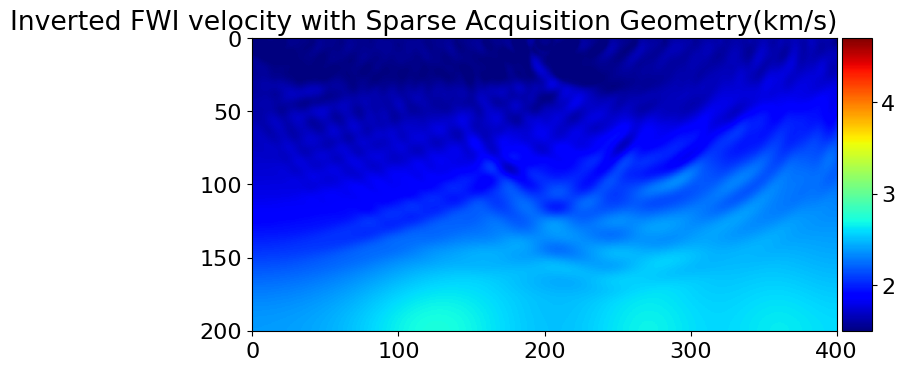

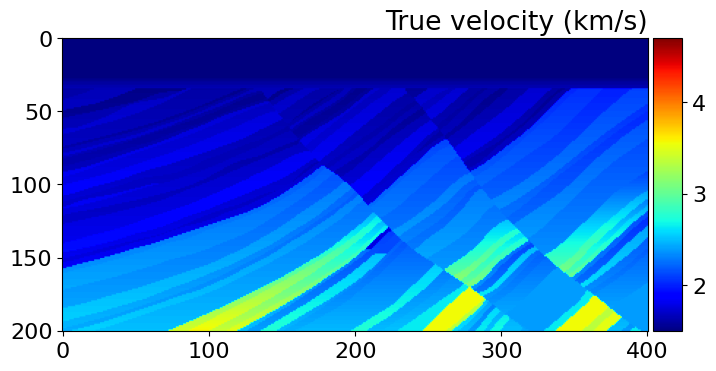

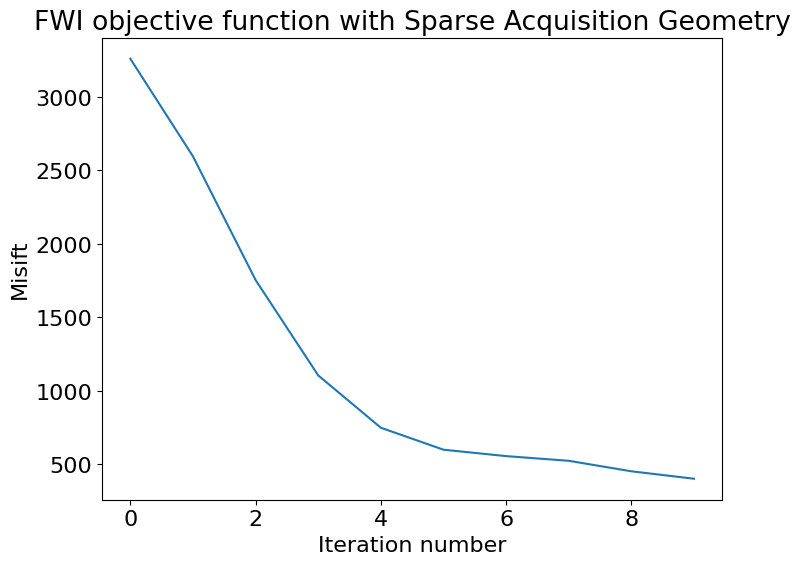

Objective value is     48589.4   at iteration   1
Objective value is     33345.4   at iteration   2
Objective value is     24931.8   at iteration   3
Objective value is     19919.7   at iteration   4
Objective value is     18061.2   at iteration   5
Objective value is     20146.1   at iteration   6
Objective value is     13979.0   at iteration   7
Objective value is     12211.6   at iteration   8
Objective value is     10519.1   at iteration   9
Objective value is      9650.1   at iteration  10


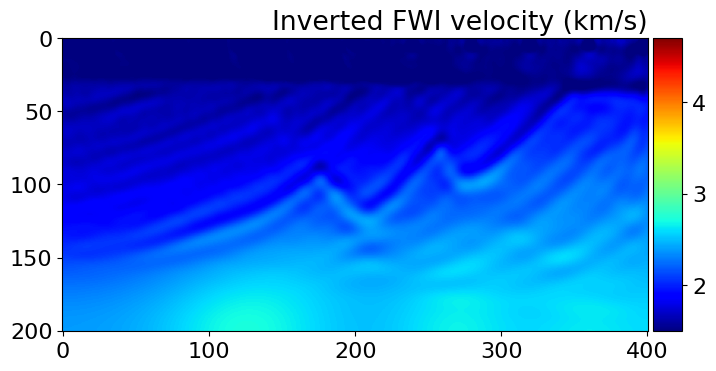

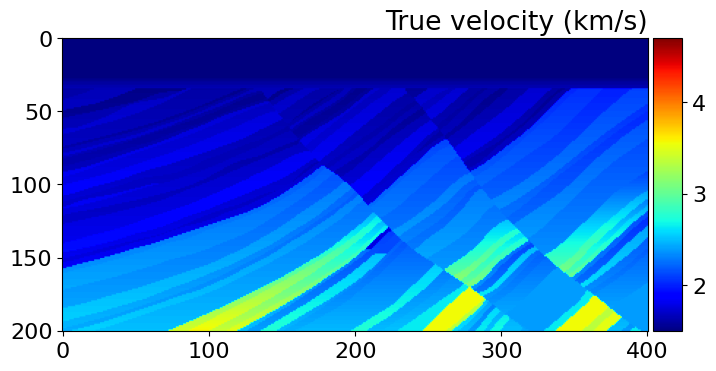

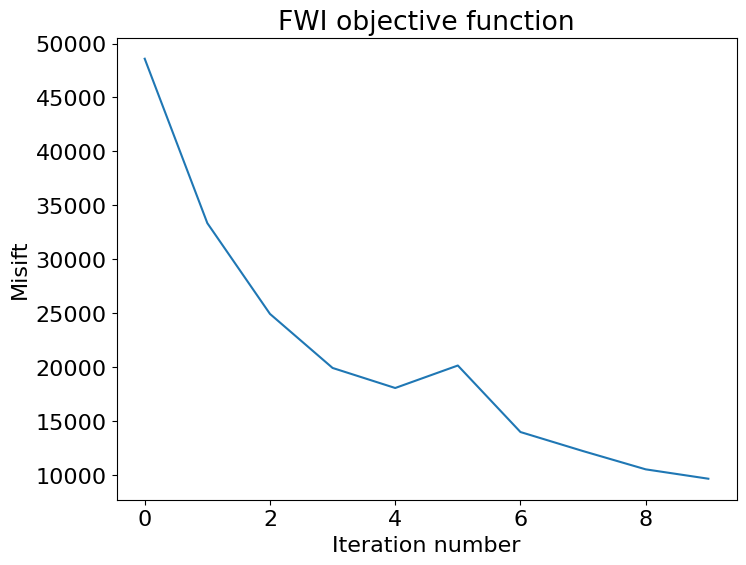

Objective value is    208523.5   at iteration   1
Objective value is    140867.8   at iteration   2
Objective value is    108023.8   at iteration   3
Objective value is     89945.7   at iteration   4
Objective value is     78730.0   at iteration   5
Objective value is     78755.4   at iteration   6
Objective value is    497834.9   at iteration   7
Objective value is    166375.7   at iteration   8
Objective value is     66903.9   at iteration   9
Objective value is     76778.1   at iteration  10


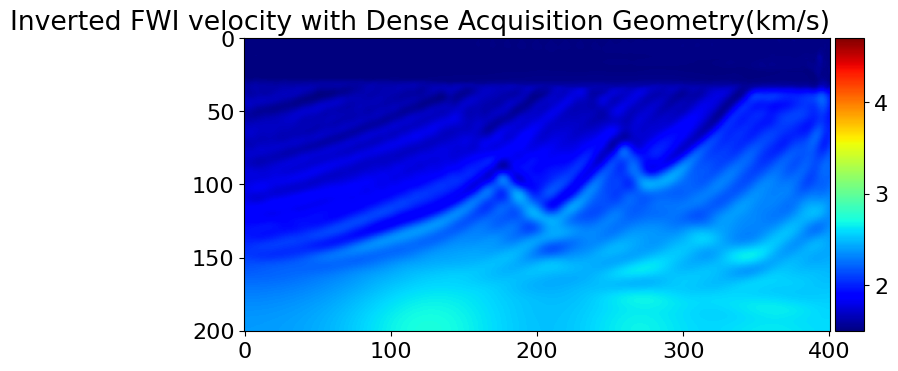

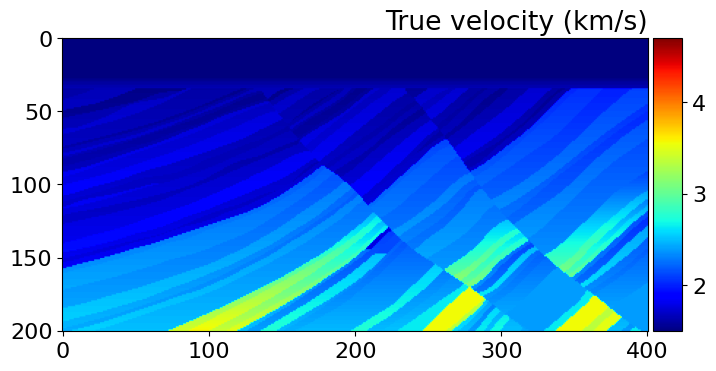

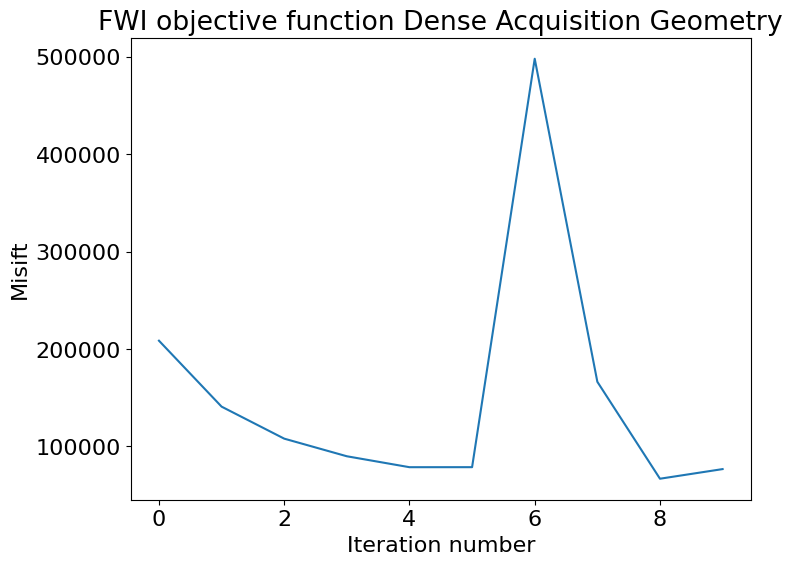

In [8]:
#set source number = (11-1/2)+1, and receiver number = (101-1/2) +1
nsrc=[3,11,41]; nrcv=[21,101,401]

#set 11*2 source locations
for i in range (len(nsrc)):
    #True Vp model
    model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

    #Smooth/Initial Vp model
    model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")
    
    src_loc = np.empty((nsrc[i], 2), dtype=np.float32)
    src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc[i])
    src_loc[:, 1] = 20.

    #set receiver locations
    rcv_loc = np.empty((nrcv[i], 2), dtype=np.float32)
    rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv[i])
    rcv_loc[:, 1] = 20.

    t0 = 0.     # Shot records starts at 0.0
    tn = 2000.  # Shot records last 2.0 second (2000 ms)
    f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
    geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
    
    isrc = 3
    geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                                t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(model, geometry, space_order=4)

    #Define forward modeling of one source
    def modeling_1src(vp_in):    
        # Create symbols to hold the data
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        # Generate modeled data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute modeled data and full forward wavefield u0 from smooth model
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        return d_obs, d_syn

    #Genearte modeled shot data of both true and smooth velocity models
    record, record0 = modeling_1src(model0.vp)

    # Function to create FWI gradient kernel 
    def fwi_gradient(vp_in):    
        # Create symbols to hold the gradient, data residual and data
        grad = Function(name="grad", grid=model.grid)
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometry.time_axis,
                            coordinates=geometry.rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        objective = 0.
        for j in range(nsrc[i]):
            # Update source location
            geometry.src_positions[0, :] = src_loc[j, :]
            # Generate true data "d_obs" from true model
            _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
            # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
            _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
            # Compute data "residual" from "d_obs" and "d_syn"
            compute_residual(residual, d_obs, d_syn)
            # Update objective function 
            objective += .5 * norm(residual)**2
            # Derive FWI gradient "grad" 
            solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        return objective, grad

    # Function to perform the gradient decent update (with box constraints)
    from sympy import Min, Max
    def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
        """
        Apply gradient update in-place to vp with box constraint
        """
        update = vp + alpha * direction
        update_eq = Eq(vp, Max(Min(update, vmax), vmin))
        Operator(update_eq)()

    # Run FWI with gradient descent
    fwi_iterations = 10
    objective = np.zeros((fwi_iterations, 1))
    for k in range(0, fwi_iterations):
        # Compute the current FWI objective function and gradient
        objective[k], direction = fwi_gradient(model0.vp)
        
        alpha = .05/mmax(direction) # We need to work out what values alpha can take

        # Update the velocity model in-place and enforce min/max value clips
        update_with_box(model0.vp, alpha, direction)
        
        # Log the progress of objective function value
        print('Objective value is %11.1f   at iteration %3d' % (objective[k], k+1))
        
    from examples.seismic import plot_image

    # Plot inverted velocity model from FWI
    if i == 0:
        plt.title('Inverted FWI velocity with Sparse Acquisition Geometry(km/s)', loc='right')
    if i == 1:
        plt.title('Inverted FWI velocity (km/s)', loc='right')
    if i == 2:
        plt.title('Inverted FWI velocity with Dense Acquisition Geometry(km/s)', loc='right')
    plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

    # Plot True velocity model
    plt.title('True velocity (km/s)', loc='right')
    plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
    
    # plot objective function
    plt.plot(objective)
    plt.xlabel('Iteration number')
    plt.ylabel('Misift')
    if i == 0: 
        plt.title('FWI objective function with Sparse Acquisition Geometry')
    if i == 1:
        plt.title('FWI objective function')
    if i == 2: 
        plt.title('FWI objective function Dense Acquisition Geometry')
    plt.show()


### Varying the source and receiver position:

#### Inline Geometry
 In this configuration, we can place the sources and receivers in a straight line along the x-axis. For example, we can place the sources and receivers at x-coordinates. This geometry may provide good resolution in the horizontal direction, but may result in poor vertical resolution.

 #### Crossline Geometry
  In this configuration, we can place the sources and receivers in a straight line along the y-axis. For example, we can place the sources and receivers at z-coordinates. This geometry may provide good resolution in the vertical direction, but may result in poor horizontal resolution.

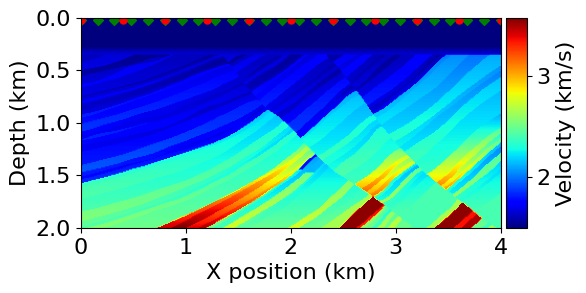

1 warning generated.


Objective value is     67970.8   at iteration   1


1 warning generated.


Objective value is     50492.5   at iteration   2


1 warning generated.


Objective value is     37204.2   at iteration   3


1 warning generated.


Objective value is     29595.9   at iteration   4


1 warning generated.


Objective value is     23962.4   at iteration   5


1 warning generated.


Objective value is     20754.4   at iteration   6


1 warning generated.


Objective value is     18994.7   at iteration   7


1 warning generated.


Objective value is     16420.2   at iteration   8


1 warning generated.


Objective value is     16609.4   at iteration   9


1 warning generated.


Objective value is     13008.6   at iteration  10


1 warning generated.


Objective value is     11445.9   at iteration  11


1 warning generated.


Objective value is     10616.0   at iteration  12


1 warning generated.


Objective value is     17475.4   at iteration  13


1 warning generated.


Objective value is      8770.8   at iteration  14


1 warning generated.


Objective value is      7485.4   at iteration  15


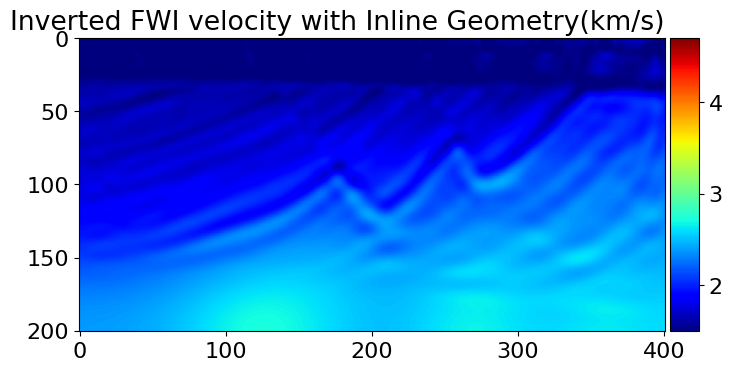

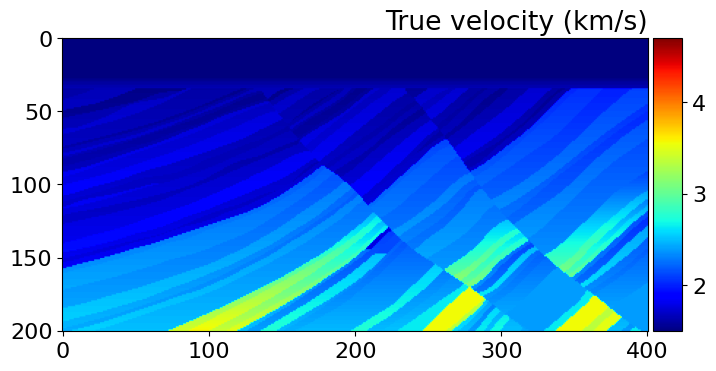

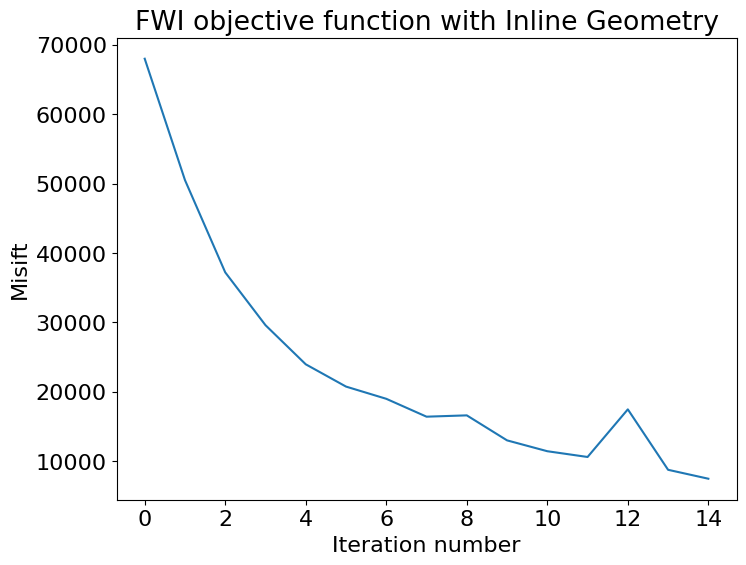

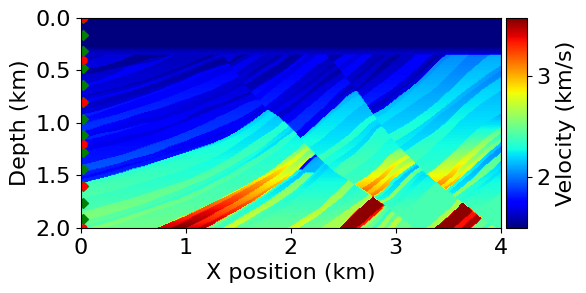

1 warning generated.


Objective value is      2812.4   at iteration   1


1 warning generated.


Objective value is      1957.3   at iteration   2


1 warning generated.


Objective value is      1241.0   at iteration   3


1 warning generated.


Objective value is       765.7   at iteration   4


1 warning generated.


Objective value is       511.6   at iteration   5


1 warning generated.


Objective value is       395.6   at iteration   6


1 warning generated.


Objective value is       321.8   at iteration   7


1 warning generated.


Objective value is       414.1   at iteration   8


1 warning generated.


Objective value is       229.2   at iteration   9


1 warning generated.


Objective value is       202.6   at iteration  10


1 warning generated.


Objective value is      1138.6   at iteration  11


1 warning generated.


Objective value is       587.7   at iteration  12


1 warning generated.


Objective value is       259.6   at iteration  13


1 warning generated.


Objective value is       147.3   at iteration  14


1 warning generated.


Objective value is       189.8   at iteration  15


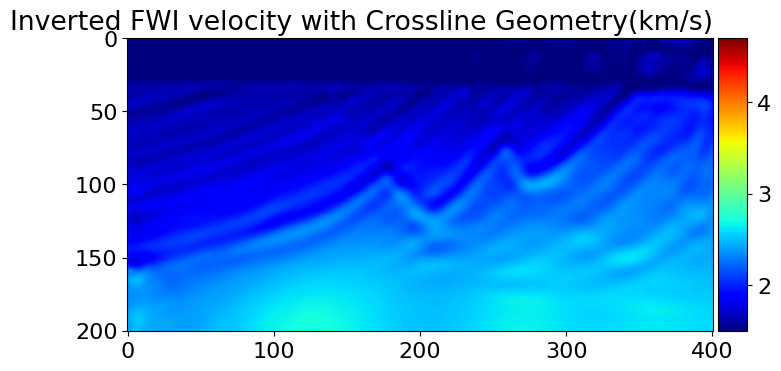

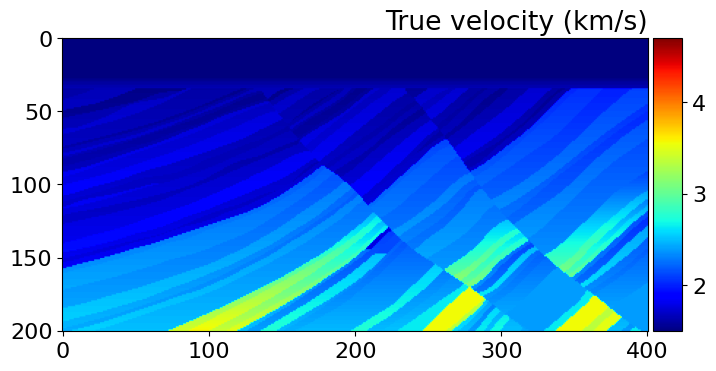

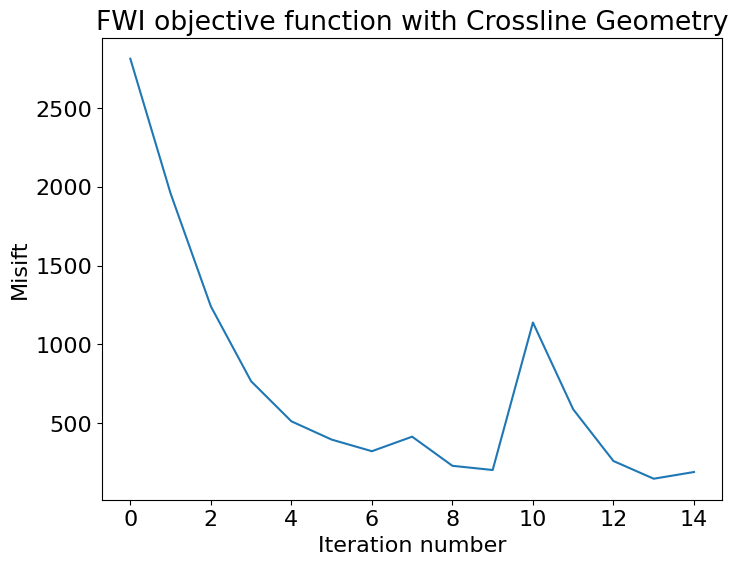

In [12]:
from examples.seismic.plotting import plot_velocity

#set source number = (11-1/2)+1, and receiver number = (101-1/2) +1
nsrc= 11; nrcv= 101


#set receiver and src locations
for i in range (2):
    src_loc = np.empty((11, 2), dtype=np.float32)
    rcv_loc = np.empty((101, 2), dtype=np.float32)
    #True Vp model
    model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

    #Smooth/Initial Vp model
    model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")
    
    if i == 0:
        src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=11)
        src_loc[:, 1] = 20.
        
        rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=101)
        rcv_loc[:, 1] = 20.
    
    if i == 1:
        src_loc[:, 0] = 20.
        src_loc[:, 1] = np.linspace(0., model.domain_size[0], num=11)
        
        rcv_loc[:, 0] = 20.
        rcv_loc[:, 1] = np.linspace(0., model.domain_size[0], num=101)
    
    if i == 2:
        src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=11)
        src_loc[:, 1] = 20.
        
        rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=101)
        rcv_loc[:, 1] = 20.
        

    t0 = 0.     # Shot records starts at 0.0
    tn = 2000.  # Shot records last 2.0 second (2000 ms)
    f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
    geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
    
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.subplot(2,1,1); plot_velocity(model, source=src_loc, receiver=rcv_loc[::4]); # Plot every one in four receivers.
    plt.title('Acquisition geometry + velocity (km/s)', loc='right')
    
    isrc = 3
    geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                                t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(model, geometry, space_order=4)

    #Define forward modeling of one source
    def modeling_1src(vp_in):    
        # Create symbols to hold the data
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        # Generate modeled data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute modeled data and full forward wavefield u0 from smooth model
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        return d_obs, d_syn

    #Genearte modeled shot data of both true and smooth velocity models
    record, record0 = modeling_1src(model0.vp)

    # Function to create FWI gradient kernel 
    def fwi_gradient(vp_in):    
        # Create symbols to hold the gradient, data residual and data
        grad = Function(name="grad", grid=model.grid)
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometry.time_axis,
                            coordinates=geometry.rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        objective = 0.
        for j in range(nsrc):
            # Update source location
            geometry.src_positions[0, :] = src_loc[j, :]
            # Generate true data "d_obs" from true model
            _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
            # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
            _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
            # Compute data "residual" from "d_obs" and "d_syn"
            compute_residual(residual, d_obs, d_syn)
            # Update objective function 
            objective += .5 * norm(residual)**2
            # Derive FWI gradient "grad" 
            solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        return objective, grad

    # Function to perform the gradient decent update (with box constraints)
    from sympy import Min, Max
    def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
        """
        Apply gradient update in-place to vp with box constraint
        """
        update = vp + alpha * direction
        update_eq = Eq(vp, Max(Min(update, vmax), vmin))
        Operator(update_eq)()

    # Run FWI with gradient descent
    fwi_iterations = 15
    objective = np.zeros((fwi_iterations, 1))
    for k in range(0, fwi_iterations):
        # Compute the current FWI objective function and gradient
        objective[k], direction = fwi_gradient(model0.vp)
        
        alpha = .05/mmax(direction) # We need to work out what values alpha can take

        # Update the velocity model in-place and enforce min/max value clips
        update_with_box(model0.vp, alpha, direction)
        
        # Log the progress of objective function value
        print('Objective value is %11.1f   at iteration %3d' % (objective[k], k+1))
        
    from examples.seismic import plot_image

    # Plot inverted velocity model from FWI
    if i == 0:
        plt.title('Inverted FWI velocity with Inline Geometry(km/s)', loc='right')
    if i == 1:
        plt.title('Inverted FWI velocity with Crossline Geometry(km/s)', loc='right')
        
    plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

    # Plot True velocity model
    plt.title('True velocity (km/s)', loc='right')
    plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
    
    # plot objective function
    plt.plot(objective)
    plt.xlabel('Iteration number')
    plt.ylabel('Misift')
    if i == 0: 
        plt.title('FWI objective function with Inline Geometry')
    if i == 1:
        plt.title('FWI objective function with Crossline Geometry')
    plt.show()


### Varying the source and receiver position: depth

Varying the depth of the source and receiver locations can have a significant impact on the quality of the FWI image. Here are a few examples of different acquisition geometries and their effects:

#### Shallow source and receiver spacing
 In this configuration, the sources and receivers are placed at shallow depths, closer to the surface. This can result in a better image of the shallow subsurface structures, such as sedimentary layers and near-surface anomalies. However, this configuration may not be effective for imaging deeper structures as the waves may not penetrate deeply enough.

#### Deep source and receiver spacing
In this configuration the sources and receivers are placed at deeper depths, allowing for better imaging of deeper structures. However, this configuration may not be effective for imaging shallow structures as the waves may not reach the surface.

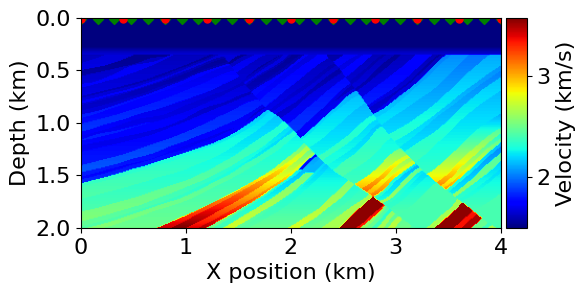

1 warning generated.


Objective value is     40828.2   at iteration   1


1 warning generated.


Objective value is     30472.6   at iteration   2


1 warning generated.


Objective value is     22920.0   at iteration   3


1 warning generated.


Objective value is     18296.9   at iteration   4


1 warning generated.


Objective value is     14900.9   at iteration   5


1 warning generated.


Objective value is     12280.2   at iteration   6


1 warning generated.


Objective value is     10550.4   at iteration   7


1 warning generated.


Objective value is      9090.7   at iteration   8


1 warning generated.


Objective value is      8247.4   at iteration   9


1 warning generated.


Objective value is      7615.8   at iteration  10


1 warning generated.


Objective value is      6842.5   at iteration  11


1 warning generated.


Objective value is      9554.6   at iteration  12


1 warning generated.


Objective value is      5561.6   at iteration  13


1 warning generated.


Objective value is      4853.1   at iteration  14


1 warning generated.


Objective value is      5547.2   at iteration  15


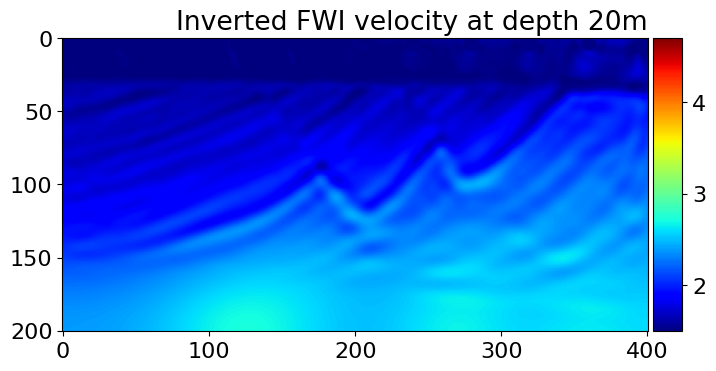

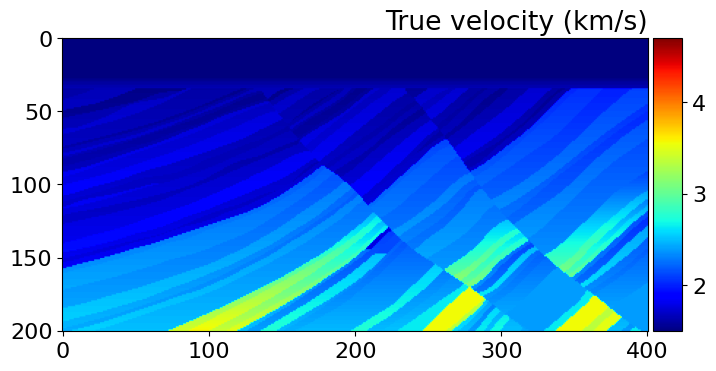

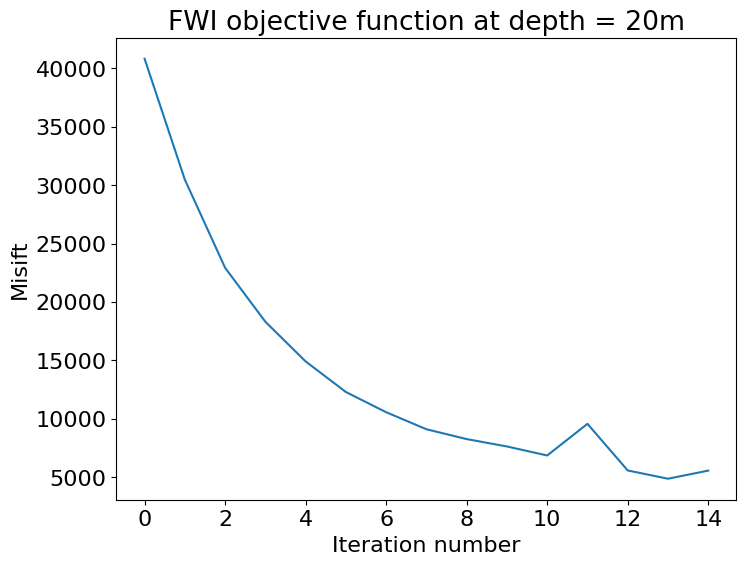

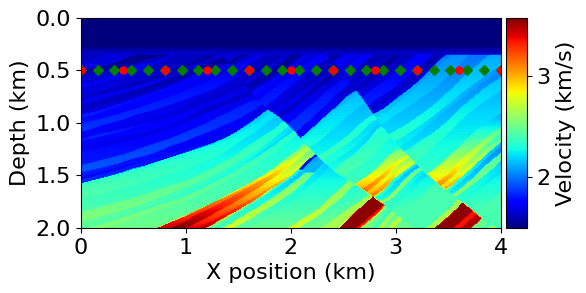

1 warning generated.


Objective value is    175970.9   at iteration   1


1 warning generated.


Objective value is    254368.7   at iteration   2


1 warning generated.


Objective value is    166752.3   at iteration   3


1 warning generated.


Objective value is     98844.5   at iteration   4


1 warning generated.


Objective value is     57003.6   at iteration   5


1 warning generated.


Objective value is     47947.9   at iteration   6


1 warning generated.


Objective value is    415105.3   at iteration   7


1 warning generated.


Objective value is    290114.0   at iteration   8


1 warning generated.


Objective value is    180176.5   at iteration   9


1 warning generated.


Objective value is     92795.5   at iteration  10


1 warning generated.


Objective value is     37885.1   at iteration  11


1 warning generated.


Objective value is     37539.6   at iteration  12


1 warning generated.


Objective value is    557914.0   at iteration  13


1 warning generated.


Objective value is    422067.3   at iteration  14


1 warning generated.


Objective value is    294580.2   at iteration  15


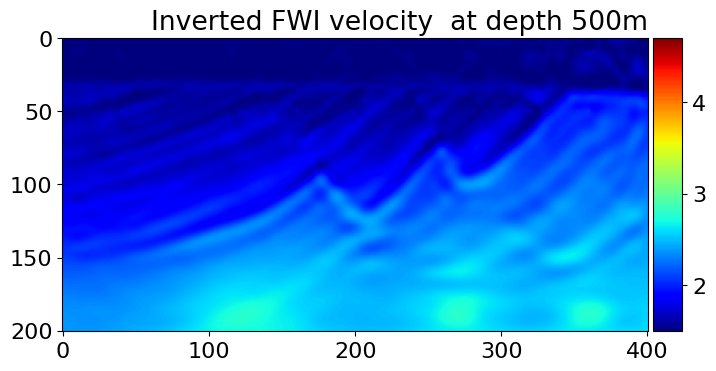

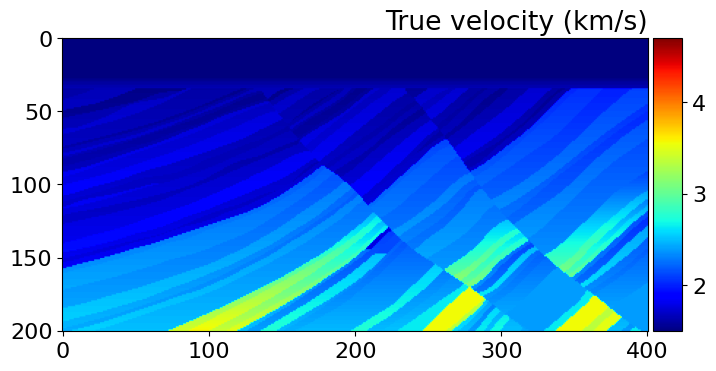

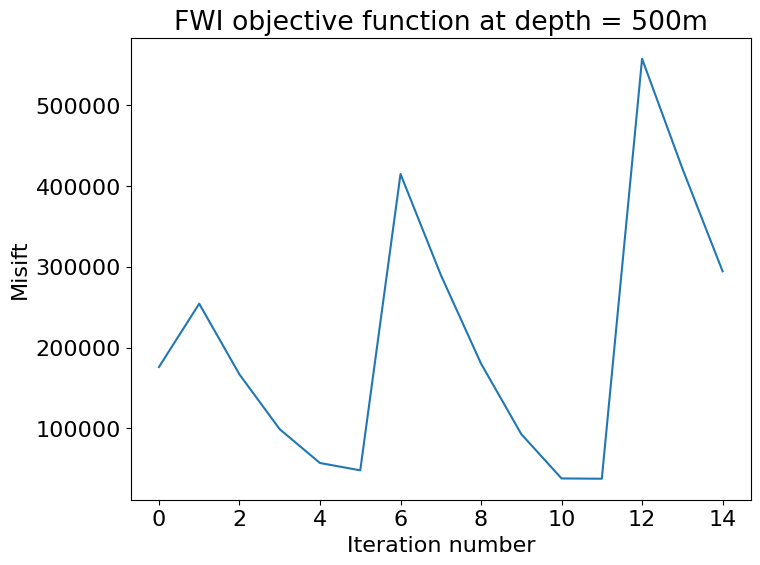

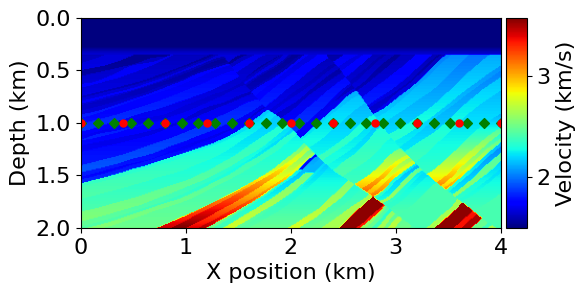

1 warning generated.


Objective value is    138700.1   at iteration   1


1 warning generated.


Objective value is     87203.5   at iteration   2


1 warning generated.


Objective value is     67217.2   at iteration   3


1 warning generated.


Objective value is     52501.9   at iteration   4


1 warning generated.


Objective value is     39361.3   at iteration   5


1 warning generated.


Objective value is     32075.6   at iteration   6


1 warning generated.


Objective value is     38485.9   at iteration   7


1 warning generated.


Objective value is     27308.3   at iteration   8


1 warning generated.


Objective value is     22997.0   at iteration   9


1 warning generated.


Objective value is     20192.5   at iteration  10


1 warning generated.


Objective value is     17893.9   at iteration  11


1 warning generated.


Objective value is     23901.3   at iteration  12


1 warning generated.


Objective value is     15155.3   at iteration  13


1 warning generated.


Objective value is     14417.1   at iteration  14


1 warning generated.


Objective value is     69858.2   at iteration  15


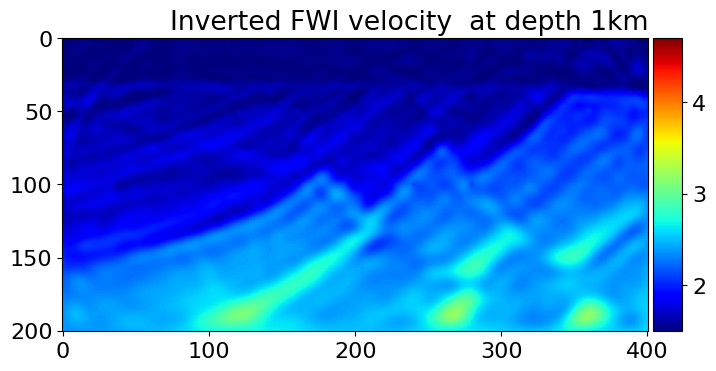

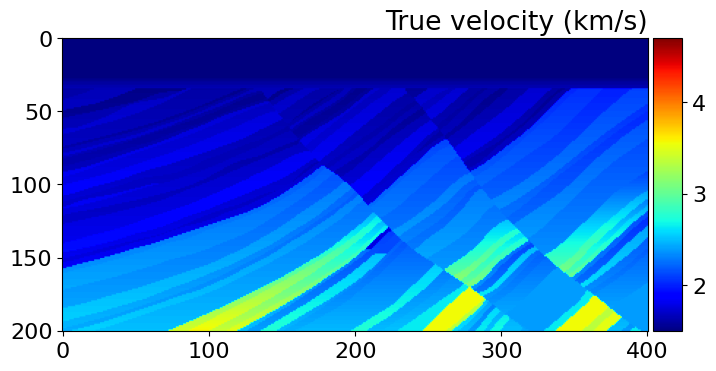

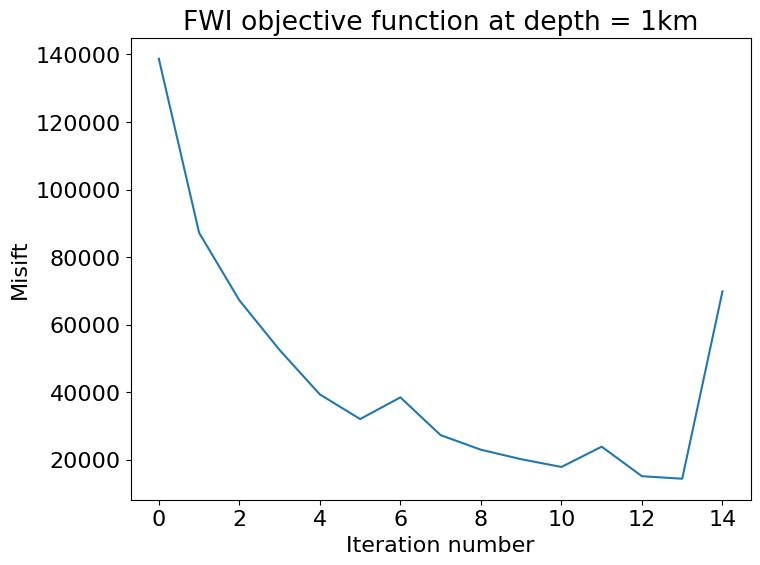

In [16]:
src_depths = [20., 500., 1000.]  # Depths of source locations in meters
rec_depths = [20., 500., 1000.]  # Depths of receiver locations in meters

from examples.seismic.plotting import plot_velocity

#set source number = (11-1/2)+1, and receiver number = (101-1/2) +1
nsrc= 11; nrcv= 101


#set receiver and src locations
for i in range (3):
    #True Vp model
    model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

    #Smooth/Initial Vp model
    model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")
    
    src_loc = np.empty((11, 2), dtype=np.float32)
    rcv_loc = np.empty((101, 2), dtype=np.float32)
     
    src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=11)
    src_loc[:, 1] = src_depths[i]
    
    rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=101)
    rcv_loc[:, 1] = rec_depths[i]

        

    t0 = 0.     # Shot records starts at 0.0
    tn = 2000.  # Shot records last 2.0 second (2000 ms)
    f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
    geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
    
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.subplot(2,1,1); plot_velocity(model, source=src_loc, receiver=rcv_loc[::4]); # Plot every one in four receivers.
    plt.title('Acquisition geometry + velocity (km/s)', loc='right')
    
    isrc = 3
    geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                                t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(model, geometry, space_order=4)

    #Define forward modeling of one source
    def modeling_1src(vp_in):    
        # Create symbols to hold the data
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        # Generate modeled data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute modeled data and full forward wavefield u0 from smooth model
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        return d_obs, d_syn

    #Genearte modeled shot data of both true and smooth velocity models
    record, record0 = modeling_1src(model0.vp)

    # Function to create FWI gradient kernel 
    def fwi_gradient(vp_in):    
        # Create symbols to hold the gradient, data residual and data
        grad = Function(name="grad", grid=model.grid)
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometry.time_axis,
                            coordinates=geometry.rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        objective = 0.
        for j in range(nsrc):
            # Update source location
            geometry.src_positions[0, :] = src_loc[j, :]
            # Generate true data "d_obs" from true model
            _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
            # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
            _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
            # Compute data "residual" from "d_obs" and "d_syn"
            compute_residual(residual, d_obs, d_syn)
            # Update objective function 
            objective += .5 * norm(residual)**2
            # Derive FWI gradient "grad" 
            solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        return objective, grad

    # Function to perform the gradient decent update (with box constraints)
    from sympy import Min, Max
    def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
        """
        Apply gradient update in-place to vp with box constraint
        """
        update = vp + alpha * direction
        update_eq = Eq(vp, Max(Min(update, vmax), vmin))
        Operator(update_eq)()

    # Run FWI with gradient descent
    fwi_iterations = 15
    objective = np.zeros((fwi_iterations, 1))
    for k in range(0, fwi_iterations):
        # Compute the current FWI objective function and gradient
        objective[k], direction = fwi_gradient(model0.vp)
        
        alpha = .05/mmax(direction) # We need to work out what values alpha can take

        # Update the velocity model in-place and enforce min/max value clips
        update_with_box(model0.vp, alpha, direction)
        
        # Log the progress of objective function value
        print('Objective value is %11.1f   at iteration %3d' % (objective[k], k+1))
        
    from examples.seismic import plot_image

    # Plot inverted velocity model from FWI
    if i == 0:
        plt.title('Inverted FWI velocity at depth 20m', loc='right')
    if i == 1:
        plt.title('Inverted FWI velocity  at depth 500m', loc='right')
    if i == 2:
        plt.title('Inverted FWI velocity  at depth 1km', loc='right')
        
    plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

    # Plot True velocity model
    plt.title('True velocity (km/s)', loc='right')
    plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
    
    # plot objective function
    plt.plot(objective)
    plt.xlabel('Iteration number')
    plt.ylabel('Misift')
    if i == 0: 
        plt.title('FWI objective function at depth = 20m')
    if i == 1:
        plt.title('FWI objective function at depth = 500m')
    if i == 2: 
        plt.title('FWI objective function at depth = 1km')
    plt.show()